## Introdução

O objetivo deste projeto é gerar estimadores para a resposta ao impulso de um sistema 'desconhecido':
 - No caso, descobrir qual a resposta ao impulso de uma garrafa;

[Projeto2.pdf](https://github.com/tallesviana/Stochastic_processes/blob/master/Proj%232/res/Estimador.pdf) :
_" [...] A estimação da resposta ao impulso pode ser feita colocando um ruído branco na entrada do sistema, observando sua saída, e fazendo algumas operações. Por exemplo, para medir a resposta ao impulso da garrafa, podemos colocar um alto falante tocando um ruído branco conhecido, w[k], medir com um microfone o áudio resultante dentro da garrafa, r[k], e usar esses dois sinais para a estimação. [...] "_

Importanto as bibliotecas necessárias:

In [2]:
%matplotlib inline
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

---
### Qual o output simulado do sistema ?

Diretamente da proposta do projeto [Projeto2.pdf](https://github.com/tallesviana/Stochastic_processes/blob/master/Proj%232/res/Estimador.pdf), iremos simular o sinal passando pelo sistema:

_" [...] Antes de começar, usar um alto falante para medir a resposta ao impulso
é muito trabalhoso para os fins desse projeto. Vamos então usar a resposta
ao impulso da garrafa do vídeo acima e simular esse experimento. Para isso,
você vai ler o arquivo de áudio com a resposta ao impulso, **h[k]**, gerar o ruído
de excitação **w[k]** e o ruído de leitura **n[k]**, e vai simular a gravação usando
uma convolução: **r[k] = w[k] * h[k] + n[k]**. Assuma que o ruído de leitura
tem variância 0.01. [...] "_

Sendo assim, nosso sinal de saída é:

\begin{equation*}
r[k] = w[k] * h[k] + n[k]
\end{equation*}

In [15]:
## Simulador do Sinal de Saída     w[k] ---|h[k]|---->  r[k]

def sim_output_measurement(impulse_response, noise_samples=10000):

  w = np.random.normal(loc=0, scale=1, size=noise_samples)

  # convolve with the impulse response h[k]
  r_k = np.convolve(w, h, mode='full')

  #then, sum with the reading noise N - (0, 0.1) with the size of the convolution
  r_k = r_k[:noise_samples] + np.random.normal(loc=0, scale=0.1, size=noise_samples)

  return r_k, w

---
### Como verificar a qualidade do estimador?

Função que verifica a qualidade do estimador baseado na distância entre o estimador e a resposta ao impulso original:

\begin{equation*}
erro = \frac{\sum | h[k] - \hat{h}[k] |^2}{\sum | h[k] |^2}
\end{equation*}

In [4]:
def estimation_error(estimator, reference):
  error = np.sum((reference - estimator) ** 2)/np.sum(reference ** 2)
  return error

Função para plotar as formas de onda:

In [13]:
def plot_estimators(estimated, real):
  plt.plot(real, label='Real');
  plt.plot(estimated, alpha=0.6, label='Estimated');
  plt.title("Impulse response comparison: Estimator vs Real")
  plt.xlabel(r'$k$')
  plt.ylabel("Amplitude")
  if len(estimated) > 1:
    plt.legend();
  plt.show();
  print("Erro do estimador de: {0:.3f} %".format(estimation_error(estimated, real)*100))

---


## Carregando o aúdio da responsa ao impulso

Fazendo a normalização da série e truncando em 6000 samples

In [6]:
audio_garrafa = "res/Garrafa.wav"

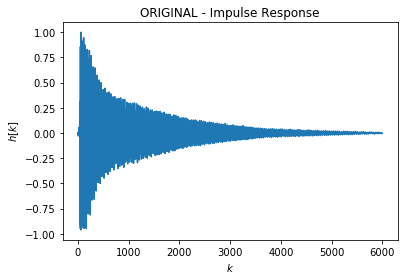

In [7]:
srate, h = wavfile.read(audio_garrafa)
h = h[:6000]/np.max(np.abs(h), axis=0)

plt.plot(h)
plt.title("ORIGINAL - Impulse Response")
plt.ylabel(r'$h[k]$')
plt.xlabel(r'$k$')
plt.show()

---

# 2 - Estimação por Correlação

## 2.1 - Demonstração

A correlação cruzada de duas sequência pode ser estimada por:

\begin{equation*}
\rho [k] = \frac{1}{K} \sum_{m=0}^{K} r[m] w[m-k]
\end{equation*}

Tal correlação pode ser obtida passasando o mesmo sinal **_r[k]_** por um filtro com resposta **_w[-k]_** :

## 2.2 - O estimador

## 2.3 - Implementação

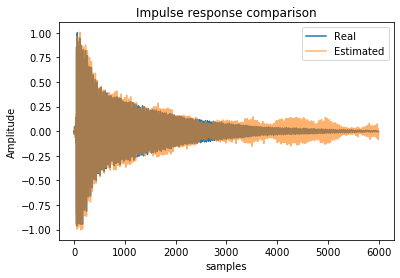

Erro do estimador de: 7.493 %


In [8]:
# Definindo o número de samples da nossa excitação
num_samples_excitation = 60000

# Pegando o sinal do output e o de entrada
r_k, w_noise = sim_output_measurement(h, num_samples_excitation)

#
#  Correlação cruzada entre a saída e a entrada
#

p_k = np.correlate(r_k, w_noise, 'full')
p_k = p_k/len(r_k)

#
#  Nosso primeiro estimador é dado abaixo
#

h_est =p_k[num_samples_excitation-1:num_samples_excitation+len(h)-1]

plot_estimators(h_est, h)

---

# 3 - Melhorando a estimação

In [9]:
# PODEMOS FAZER UMA MÉDIA DAS VARIAS CORRELAÇÕES CRUZADAS
# DE DIFERENTES REALIZAÇÕES
def multiple_cross_correlations(h, num_samples_excitation, iterations):
  
  ccfs = 0

  for i in range(iterations):

      # Obtendo o output de uma realização
      output, w_noise = sim_output_measurement(h, num_samples_excitation)

      # Obtendo a correlação
      correlation = np.correlate(output, w_noise, mode='full')/len(output)

      ccfs = ccfs + correlation

  return ccfs/iterations

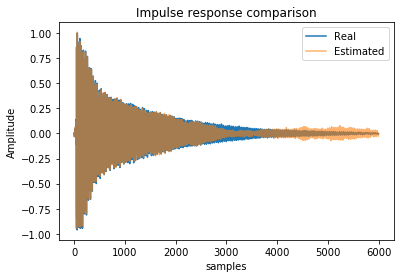

Erro do estimador de: 2.090 %
Erro do estimador de: 2.089858733297311 %


In [12]:
# Escolha os dois parâmetros abaixo!

num_samples=60000
iterations = 5

estimator = multiple_cross_correlations(h, num_samples, iterations)

estimator = estimator[num_samples-1:num_samples+len(h)-1]
plot_estimators(estimator, h)

---

# 4 - Mínimo Erro Quadrático Médio (MMSE)

---
---
---

### References used to make this project

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

Example of markdown format:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
z & = 2 \\
r[k] & = w[k] * h[k] + n[k]
\end{align}